In [1]:
# existing imports
from dataclasses import dataclass
import sys
from tqdm import tqdm
# third party imports
import scipy.integrate as integrate
import scipy.sparse as sparse
import scipy.linalg
import numpy as np
np.random.seed(101101)
# local imports
sys.path.insert(0,'..')
from src.matrices import get_J_matrix
# display imports
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import Video

<h1>02-Simulate Evolution of Neural System</h1>
Now we are going to take the matrices for J and H generated previously, and use them as update values to a differential equation. Parameters pulled from last notebook for simulation here.

In [2]:
import src.matrices
parameters = src.matrices.paper_parameters
print(parameters)
N = 200
u, w, alpha, beta, gamma = parameters[2].values()
matrix = get_J_matrix(N,**parameters[2])

[{'u': 0.5, 'w': 0.0, 'alpha': 1.0, 'beta': 0.0, 'gamma': 0.0}, {'u': 0.0, 'w': 0.0, 'alpha': 1.0, 'beta': 1.0, 'gamma': 1.0}, {'u': 0.5, 'w': 0.0, 'alpha': 1.0, 'beta': 1.0, 'gamma': 1.0}, {'u': 0.5, 'w': 0.5, 'alpha': 1.0, 'beta': 1.0, 'gamma': 1.0}]


<h2>Eigenvalues and Eigenvectors</h2>
Looking at the greatest eigenvalues and vectors of the matrix in our differential equation will give us an understanding the stable states of the neural system

In [3]:
lambs, vecs = scipy.linalg.eig(np.array(matrix))

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

<h2>Define Differential Equation</h2>
Here we define the differential equation as defined in Tanaka et al. equation (8)
$$
  \tau \frac{dr_i}{dt} = -r_i(t) + f[\sum_j J_{i j} r_j(t) + h_i(t)]
$$
where f is the neurons activation function, and h_i is the ith neurons external input.

In [18]:
def gaussian(x,mu,sigma):
    
    return np.exp(-(x-mu)**2 / (2 * sigma**2))

@dataclass
class StillGaussian(src.matrices.NeuronDiffEq):
    mu: np.double
    sigma: np.double
    height: float
        
    overlap: int = 10

    def external(self,t):
        x   = np.arange(0-self.overlap,self.N+self.overlap,dtype=int)
        beta = x % self.N
        alpha = gaussian(x,self.mu,self.sigma)
        
        out = np.zeros((self.N))
        for iii in range(self.N):
            out[iii] = np.sum(alpha[iii == beta])
       
        return out
    
@dataclass
class MovingGaussian(src.matrices.NeuronDiffEq):
    mu0: np.double
    vmu: np.double
    sigma: np.double
    height: float
        
    overlap: int = 10

    def external(self,t):
        x   = np.arange(0-self.overlap,self.N+self.overlap,dtype=int)
        beta = x % self.N
        alpha = gaussian(x,self.mu0 + self.vmu * t,self.sigma)
        
        out = np.zeros((self.N))
        for iii in range(self.N):
            out[iii] = np.sum(alpha[iii == beta])
       
        return out

Now we can use our class format to have children with different external inputs

<h2>Simulation Time</h2>
Now we are going to simulate the neurons as connected by the above matrix.

In [25]:
tau = 5
tspace = range(100)
r0 = np.zeros(N)
r0[:N//2] = 2.0
in_array = np.zeros((len(tspace),*r0.shape))

mu  = 0
vmu = 2
sigma = 5.0
height = 5.0
# sites = slice(0,N//3)
# neurons = NoisyNeuron(matrix,tau,N,mu,sigma)
# neurons = ConstantInput(matrix,tau,N,constant,sites)
neurons = MovingGaussian(matrix,tau,N,mu,vmu,sigma,height)
results = integrate.odeint(neurons,r0,tspace)

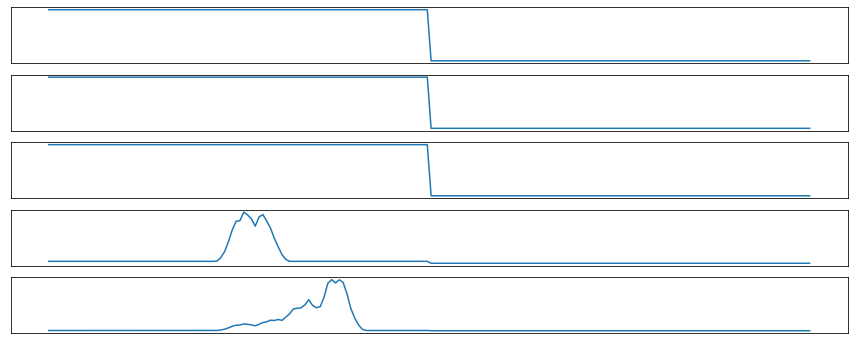

In [26]:
# n_imgs = 3
times_indices = [0,10,20,30,40]

fig, axs = plt.subplots(len(times_indices),figsize=(3*len(times_indices),6))
# metrics = np.zeros((len(kernels),*image.shape))
for index,img_i in enumerate(times_indices):

    axs[index].plot(results[img_i,...])
    axs[index].set_xticks([])
    axs[index].set_yticks([])
        
plt.show()

Reorder of eigenvectors by largest values. And selecting some to plot.

In [27]:
eig_n = 10
ordered_inds = np.argsort(lambs.real)
vecs_sp = vecs[:,ordered_inds[:eig_n]]

In [28]:
vecs_sp.shape

(200, 10)

script to write a movie of the neural state evolving over time.

102it [00:10,  9.37it/s]                         


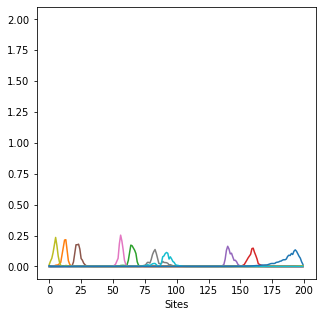

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))

for iii in range(eig_n):
    ax.plot(np.abs(vecs_sp[:,iii])**2)

line, = ax.plot(results[0,...])
# ax.axis('equal')
ax.set_xlabel('Sites')


orders = np.arange(0,len(tspace),dtype=int)
with tqdm(total=len(tspace)) as pbar:
        
    def next_image(index):
        
        line.set_ydata(results[index,...])
#         ax.set_title("{}".format(tim_stack[index]))
        pbar.update(1)
        
        return line,
            
    ani = animation.FuncAnimation(
        fig,
        next_image,
        frames=orders,
        interval=200,
        repeat=False,
        repeat_delay=100,
        blit=True
    )
#     plt.show()
    filename = "out/diffeqJ_u{}_w{}_a{}_b{}_g{}.mp4".format(u,w,alpha,beta,gamma)
    ani.save(filename)

In [30]:
Video(filename)